In [1]:
# body reconstruction
#
# finds rectangular shapes
# understand which ones could be a box
# indentifies panel's body
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# OpenCV + Python Rectangle Detection Example
# https://www.youtube.com/watch?v=T9P10FAp8Qw
# 1) https://mehmethanoglu.com.tr/blog/6-opencv-ile-dikdortgen-algilama-python.html
# https://youtu.be/HpaY0HOomAI
# # https://github.com/shibatch/rectdetect
# https://youtu.be/Fchzk1lDt7Q
# https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html
# https://stackoverflow.com/questions/44522012/rectangle-detection-tracking-using-opencv
# https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
# https://docs.opencv.org/3.4/da/d0c/tutorial_bounding_rects_circles.html
# https://cv-tricks.com/opencv-dnn/edge-detection-hed/
# https://arxiv.org/pdf/1703.10896.pdf
# https://www.youtube.com/watch?v=zzcipxzZP9E
#######
#https://stackoverflow.com/questions/57125879/improve-rectangle-contour-detection-in-image-using-opencv
#https://stackoverflow.com/questions/44295099/how-to-identify-incomplete-rectangles-in-opencv
#https://stackoverflow.com/questions/14795246/rectangular-approximation-of-contours
## use contours as array:
#https://stackoverflow.com/questions/33958977/contour-approximation-opencv
#https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html


**To make an optical form reader it is necessary to follow the necessary steps sequentially.**
1. First, we have to successfully pass the rectangle detection function. The operations performed for this are logically simple, but small adjustments lead to a lot of changes;
2. we transform a colored picture into gray, that is, gray and its tones;
3. Then we apply a bilateral filter. Every process we do is to make the objects more perceptible through the gray colored picture. For this purpose, removing small details etc. etc.
4. After eliminating the small details a little, we will use the Canny function to get corners or waypoints. With this filter, we will get a completely black and white result. (Detailed explanation about Canny function)
5. In the next steps, the geometry we are looking for is a rectangle and similar shapes will be obtained by contour and looking at the number of corners. If it has 4 corners, it will be a suitable geometry for us. We will convert the rectangle into perspective -> normal view according to the coordinates we have obtained. Thus, we will have the quadrilateral in a normal view.

In [18]:
def findRectangles(imgrect,filtype,method,imop,PARAMGAUSS,PARAMCANNY,PARAMMORPH):
    #filtype= {'bilinear','gaussian'}, filters type
    #method={'threshold'} method of binarization
    #imgcls={1,0} toggles closing operation
    #debug = 0
 
 
    # Grayscale image is requested for contour recognition
    imgrect = cv2.cvtColor(imgrect, cv2.COLOR_BGR2GRAY)
    
    if filtype=='bilinear':
        # bilinear filtering
        imgrect=cv2.bilateralFilter(imgrect , 1, 10, 120 )
    elif filtype=='gaussian':
        #gaussian blur
        imgrect=cv2.GaussianBlur(imgrect,(PARAMGAUSS,PARAMGAUSS),0)
    #else
        #no filtering
        
    if method == 'canny': 
        #use edge detection
        imgrect  = cv2.Canny( imgrect, 10, PARAMCANNY )
    else:
        #use threshold binarization
        _, imgrect = cv2.threshold(imgrect, 127, 255, 0)
    
    kernel = cv2.getStructuringElement( cv2.MORPH_RECT, ( PARAMMORPH, PARAMMORPH ) )
    if imop=='morp':
        #morphing the image
        kernel = cv2.getStructuringElement( cv2.MORPH_RECT, ( PARAMMORPH, PARAMMORPH ) )
        imgrect = cv2.morphologyEx( imgrect, cv2.MORPH_CLOSE, kernel )
    elif imop=='erate':
        # erode and dilate
        imgrect = cv2.erode(imgrect,kernel,iterations = 10)
        imgrect = cv2.dilate(imgrect,kernel,iterations = 10)
        
    

    # Check if at least one marker has been found
    #if idsR is None or len(idsR) == 0:
    #    # If no marker detected, exit
    #    print("No marker detected!")
    #    return None

    # Print found arucos
    #if debug:
    #    for i, corner in zip(idsR, cornersR):
    #        print('Detected aruco with ID: {}.'.format(i[0]))

    #======== Find contours in image ========
       
    _,contours, hierarchy = cv2.findContours(imgrect, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    if 1:
        # Identify rectangular contours
        rect_cnts = []
        areas = []
        for cnt in contours:
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.1 * peri, True)
            (x, y, w, h) = cv2.boundingRect(cnt)
            #ar = w / float(h)
            if len(approx) == 4: # shape filtering condition
                # Get the area of the rectangle, need to exclude rectangles with area less than the 
                # one of the smallest aruco
                area = cv2.contourArea(cnt)
                #rect_cnts.append(cnt)
                #areas.append(cv2.contourArea(cnt))

                # Exclude rectangles with pixel area, due to some threesholding error perhaps
                if area >= 5.0:
                    areas.append(area)
                    rect_cnts.append(cnt) # Shape is rectangle, add to the valid list
        # Now in rect_cnts[] we have only rectangular contours


        #======== Discard the contours that do not contain any aruco (multiple markers can be present in the image)

        #  j = 0
        #  in_cnt = []
        #  for aruco_n, corner_n in zip(idsR, cornersR): # for every aruco marker in image...
        #      cnt_father = []
        #      corner_n = corner_n[0] # adjust array dimensionality
        #      for cnt in rect_cnts: # for every rectangular contour...
        #         dist = cv2.pointPolygonTest(cnt, (corner_n[0][0].astype(int), corner_n[0][1].astype(int)), True) # Check if top left corner of the aruco
        #          if dist > 1.: # if the aruco is inside the contour...
        #             cnt_father.append(cnt) # add the contour in list
        #              if debug:
        #                 cv2.drawContours(imgRectDraw, [cnt], -1, (0,255,0), 2) # for debug draw the contour found
        #     if len(cnt_father) != 0:
        #         in_cnt.append(cnt_father) # check next aruco

        #if debug:
            #cv2.imshow('Aruco Containers', imgRectDraw)

        #   plt.figure(figsize=(20,10))

        #   plt.subplot(1,2,1)
        #   plt.imshow(cv2.cvtColor(imgRect, cv2.COLOR_BGR2RGB))
        #   plt.title("Original image")

        #   plt.subplot(1,2,2)
        #   plt.imshow(cv2.cvtColor(imgRectDraw, cv2.COLOR_BGR2RGB))
        #   plt.title("Aruco containers")
        #  plt.show()

        #cv2.drawContours(imgrect, rect_cnts, -1, (0,255,0), 3)

        cv2.waitKey(0)
        cv2.destroyAllWindows()
        return rect_cnts
    else:
        return contours

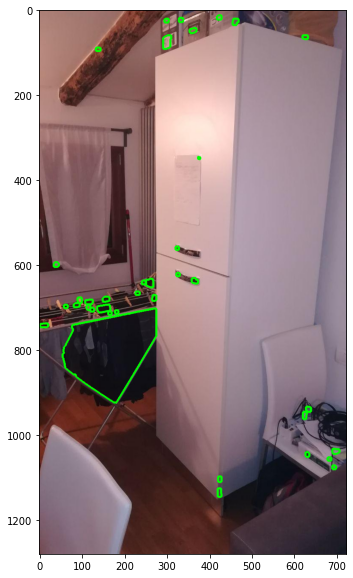

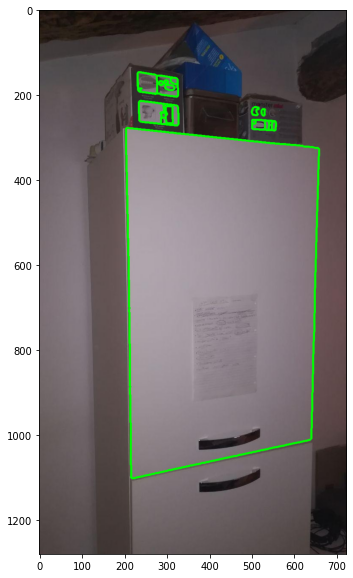

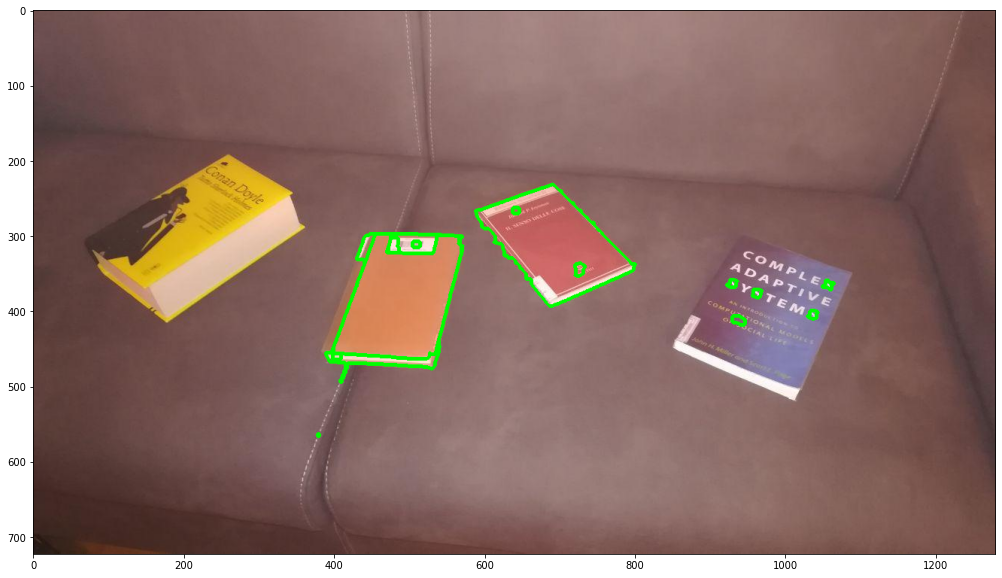

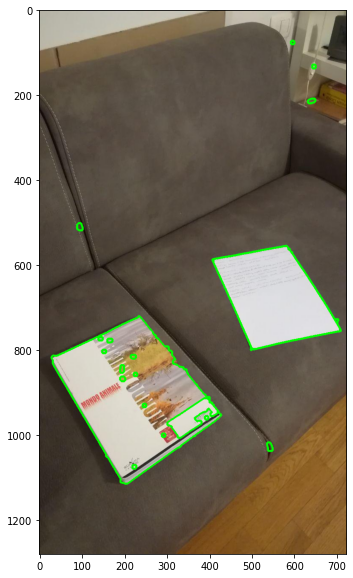

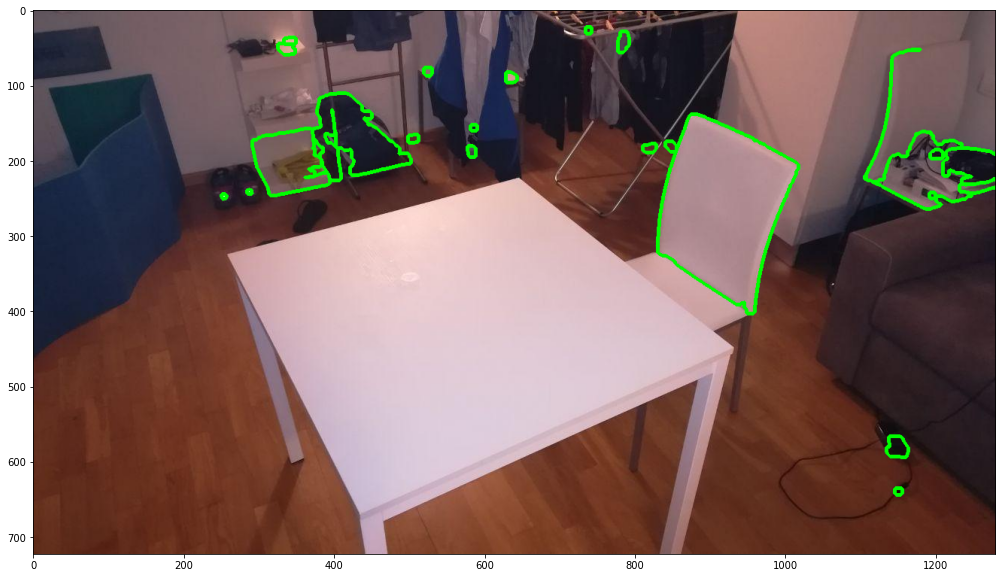

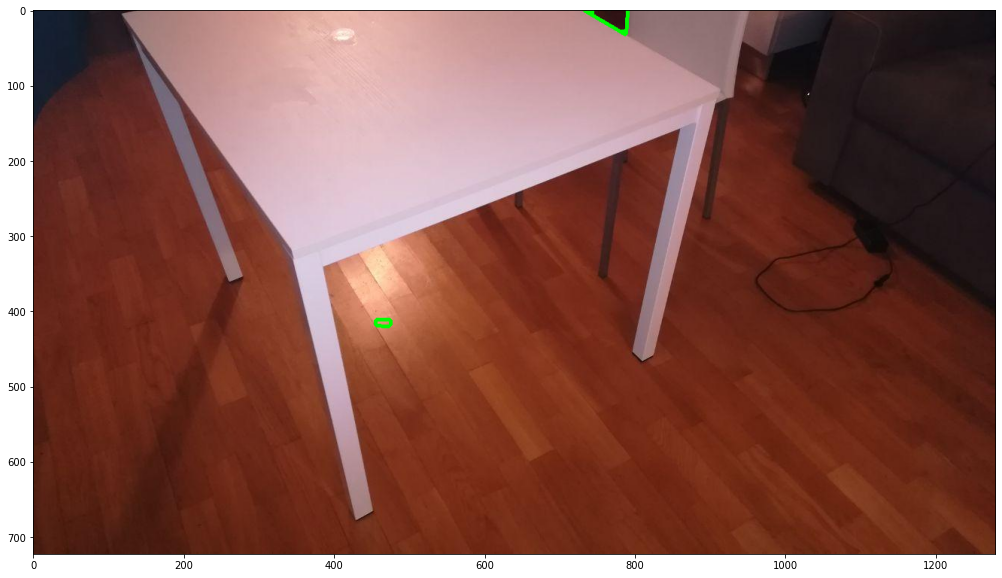

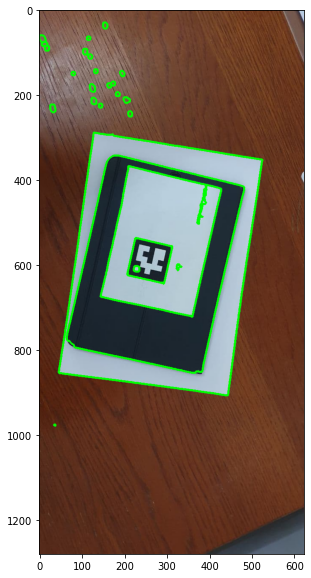

In [21]:

#param
GAUSS=5
CANNY = 250
MORPH = 7
usefilter='bilinear'
usemethod='canny'
useclosing='morp'

img1=cv2.imread("body/frigo1.jpg")
img2=cv2.imread('body/frigo2.jpg')
img3=cv2.imread('body/libri.jpg')
img4=cv2.imread('body/pag1.jpg')
img5=cv2.imread('body/tavolo1.jpg')
img6=cv2.imread('body/tavolo2.jpg')
img7=cv2.imread('../2-markers/test-imgs/double-rectangle.jpg')
#img0=np.copy(img)

imgcnts1= findRectangles(img1,usefilter,usemethod,useclosing,GAUSS,CANNY,MORPH)
cv2.drawContours(img1, imgcnts1, -1, (0,255,0), 3)
imgcnts2= findRectangles(img2,usefilter,usemethod,useclosing,GAUSS,CANNY,MORPH)
cv2.drawContours(img2, imgcnts2, -1, (0,255,0), 3)
imgcnts3= findRectangles(img3,usefilter,usemethod,useclosing,GAUSS,CANNY,MORPH)
cv2.drawContours(img3, imgcnts3,-1, (0,255,0), 3)
imgcnts4= findRectangles(img4,usefilter,usemethod,useclosing,GAUSS,CANNY,MORPH)
cv2.drawContours(img4, imgcnts4, -1, (0,255,0), 3)
imgcnts5= findRectangles(img5,usefilter,usemethod,useclosing,GAUSS,CANNY,MORPH)
cv2.drawContours(img5, imgcnts5, -1, (0,255,0), 3)
imgcnts6= findRectangles(img6,usefilter,usemethod,useclosing,GAUSS,CANNY,MORPH)
cv2.drawContours(img6, imgcnts6, -1, (0,255,0), 3)
imgcnts7= findRectangles(img7,usefilter,usemethod,useclosing,GAUSS,CANNY,MORPH)
cv2.drawContours(img7, imgcnts7, -1, (0,255,0), 3)

#print("Areas:", areas)

# Display our image
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img6, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img7, cv2.COLOR_BGR2RGB))

#plt.subplot(4,2,1)
#plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
#plt.title("all rectangles around the aruco")
#plt.subplot(4,2,2)
#plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
#plt.subplot(4,2,3)
#plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
#plt.subplot(4,2,4)
#plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
#plt.subplot(4,2,5)
#plt.imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
#plt.subplot(4,2,6)
#plt.imshow(cv2.cvtColor(img6, cv2.COLOR_BGR2RGB))
#plt.subplot(4,2,7)
#plt.imshow(cv2.cvtColor(img7, cv2.COLOR_BGR2RGB))
plt.show()

In [2]:
import cv2
import time
import numpy as np

##################
DELAY = 0.02
USE_CAM = 1
IS_FOUND = 0

MORPH = 7
CANNY = 250
##################
# 420x600 oranı 105mmx150mm gerçek boyuttaki kağıt için
_width  = 600.0
_height = 420.0
_margin = 0.0
##################

if USE_CAM: video_capture = cv2.VideoCapture(0)

corners = np.array(
    [
    [[  _margin, _margin]],
    [[ _margin, _height + _margin  ]],
    [[ _width + _margin, _height + _margin  ]],
    [[ _width + _margin, _margin ]],
    ]
)

pts_dst = np.array( corners, np.float32 )

while True :

    if USE_CAM :
        ret, rgb = video_capture.read()
    else :
        ret = 1
        rgb = cv2.imread( "opencv.jpg", 1 )

    if ( ret ):

        gray = cv2.cvtColor( rgb, cv2.COLOR_BGR2GRAY )

        gray = cv2.bilateralFilter( gray, 1, 10, 120 )

        edges  = cv2.Canny( gray, 10, CANNY )

        kernel = cv2.getStructuringElement( cv2.MORPH_RECT, ( MORPH, MORPH ) )

        closed = cv2.morphologyEx( edges, cv2.MORPH_CLOSE, kernel )
        _,contours, h = cv2.findContours( closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE )

        for cont in contours:

            # Küçük alanları pass geç
            if cv2.contourArea( cont ) > 5000 :

                arc_len = cv2.arcLength( cont, True )

                approx = cv2.approxPolyDP( cont, 0.2 * arc_len, True )

                if ( len( approx ) == 4 ):
                    IS_FOUND = 1
                    #M = cv2.moments( cont )
                    #cX = int(M["m10"] / M["m00"])abs
                    #cY = int(M["m01"] / M["m00"])
                    #cv2.putText(rgb, "Center", (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)

                    pts_src = np.array( approx, np.float32 )

                    h, status = cv2.findHomography( pts_src, pts_dst )
                    out = cv2.warpPerspective( rgb, h, ( int( _width + _margin * 2 ), int( _height + _margin * 2 ) ) )

                    cv2.drawContours( rgb, [approx], -1, ( 255, 0, 0 ), 2 )

                else : pass

        #cv2.imshow( 'closed', closed )
        #cv2.imshow( 'gray', gray )
        

        if IS_FOUND :
            cv2.namedWindow( 'out', cv2.CV_WINDOW_AUTOSIZE )
            cv2.imshow( 'out', out )

        if cv2.waitKey(27) & 0xFF == ord('q') :
            break

        if cv2.waitKey(99) & 0xFF == ord('c') :
            current = str( time.time() )
            cv2.imwrite( 'ocvi_' + current + '_edges.jpg', edges )
            cv2.imwrite( 'ocvi_' + current + '_gray.jpg', gray )
            cv2.imwrite( 'ocvi_' + current + '_org.jpg', rgb )
            print("Pictures saved")

        time.sleep( DELAY )

    else :
      #  print "Stopped"
        break

if USE_CAM : video_capture.release()
cv2.destroyAllWindows()

AttributeError: module 'cv2.cv2' has no attribute 'CV_WINDOW_AUTOSIZE'